# Long Short-Term Memory (LSTM)

Algoritma Long Short Term Memory (LSTM) adalah turunan istimewa dari Recurrent Neural Network (RNN) yang dirancang untuk mengatasi kelemahan RNN dalam menangani urutan data yang panjang. LSTM memiliki kemampuan untuk menyimpan informasi penting dalam jangka waktu yang lama, membuatnya ideal untuk berbagai aplikasi yang melibatkan data sekuensial.  
![image.png](lstm-flow.png)

# A. Menyiapkan Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# B. Memuat Data

In [2]:
data = pd.read_csv('final.csv')
data['datetime'] = pd.to_datetime(data['datetime'], format='%d/%m/%Y %H:%M:%S')
# sort data by datetime
# change datetime that has d/m/y 00:00:00, change to d+1/m/y 00:00:00
data['datetime'] = data['datetime'].apply(lambda x: x + pd.DateOffset(days=1) if x.strftime('%H:%M:%S') == '00:00:00' else x)
data = data.sort_values('datetime')

data

,datetime,choke,psig,apsig,oil,gas,water,liquid
0,2021-05-15 21:00:00,38,935,320,698.880,4.980,23.616,722.5
1,2021-05-15 21:15:00,38,935,321,822.456,4.988,32.592,855.0
2,2021-05-15 21:30:00,38,940,318,661.368,5.070,26.208,687.6
3,2021-05-15 21:45:00,38,938,317,737.664,5.061,29.232,766.9
4,2021-05-15 22:00:00,38,940,319,661.368,5.078,26.208,687.6
...,...,...,...,...,...,...,...,...
1873,2021-06-04 08:00:00,42,986,328,771.720,7.638,16.896,788.6
1874,2021-06-04 08:15:00,42,984,325,766.032,7.602,16.704,782.7
1875,2021-06-04 08:30:00,42,986,328,765.216,7.638,16.704,781.9
1876,2021-06-04 08:45:00,42,988,326,757.224,7.614,16.512,773.7


# C. Pemisahan Data Berdasarkan Nilai Choke
Termasuk menghapus kolom choke karena tidak diperlukan dalam pemodelan

## 1. Berapa choke yang ada dalam data?

In [3]:
data['choke'].value_counts()

38    854
40    645
42    379
Name: choke, dtype: int64

## 2. Memisahkan data berdasarkan nilai choke yang ada

In [4]:
data_38 = data[data['choke'] == 38].drop(['datetime', 'choke'], axis=1)
data_40 = data[data['choke'] == 40].drop(['datetime', 'choke'], axis=1)
data_42 = data[data['choke'] == 42].drop(['datetime', 'choke'], axis=1)

# Menampilkan Data
display('Data Choke 38', data_38.describe())
display('Data Choke 40', data_40.describe())
display('Data Choke 42', data_42.describe())

'Data Choke 38'

,psig,apsig,oil,gas,water,liquid
count,854.000000,854.000000,854.000000,854.000000,854.000000,854.000000
mean,1007.033958,325.594848,761.594501,5.987358,17.394857,778.921077
std,73.533621,7.364072,45.464697,0.562406,7.202383,49.189237
min,835.000000,304.000000,610.704000,4.745000,6.144000,627.800000
25%,934.250000,320.000000,733.080000,5.279250,14.976000,747.400000
50%,1050.000000,328.000000,757.560000,6.267000,16.512000,775.100000
75%,1054.000000,331.000000,788.448000,6.384000,22.704000,812.225000
max,1067.000000,340.000000,893.448000,6.579000,48.000000,923.500000


'Data Choke 40'

,psig,apsig,oil,gas,water,liquid
count,645.000000,645.000000,645.000000,645.000000,645.000000,645.000000
mean,1021.804651,331.893023,767.669991,7.038047,15.788130,783.326512
std,5.367747,5.293207,27.692167,0.059675,3.047829,27.905772
min,1004.000000,318.000000,712.440000,6.888000,7.872000,728.000000
25%,1018.000000,327.000000,747.168000,7.000000,15.936000,763.200000
50%,1022.000000,334.000000,765.216000,7.038000,16.512000,781.100000
75%,1026.000000,336.000000,786.792000,7.077000,16.896000,803.900000
max,1039.000000,340.000000,839.832000,7.230000,31.920000,858.900000


'Data Choke 42'

,psig,apsig,oil,gas,water,liquid
count,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000
mean,988.068602,326.704485,800.717636,7.557427,17.555208,818.266755
std,4.861635,2.377642,16.509230,0.066787,1.365055,16.803696
min,982.000000,320.000000,757.224000,7.292000,9.024000,773.700000
25%,985.000000,325.000000,790.080000,7.544500,17.280000,807.400000
50%,986.000000,327.000000,800.400000,7.575000,17.472000,817.900000
75%,990.000000,328.000000,815.568000,7.599000,17.856000,833.400000
max,1018.000000,333.000000,845.280000,7.673000,27.072000,863.700000


# D. Normalisasi Data

## 1. Membuat fungsi untuk normalisasi data

In [5]:
def normalize_dataframe(df, method='min-max', range_min=0.0, range_max=1.0):
    # Normalisasi Data metode Min-Max
    # df: DataFrame
    # method: metode normalisasi, standard atau min-max
    # range_min: nilai minimum setelah normalisasi, only for min-max method
    # range_max: nilai maksimum setelah normalisasi, only for min-max method
    # return: DataFrame yang sudah dinormalisasi

    assert isinstance(df, pd.DataFrame), 'df harus bertipe DataFrame'

    # Membuat salinan DataFrame
    df_normalized = df.copy()

    if method == 'standard':
        # Normalisasi menggunakan metode standard
        df_normalized = (df - df.mean()) / df.std()
        
        return df_normalized
    
    #  Iterasi setiap kolom dalam DataFrame
    for column in df.columns:
        # Ambil nilai minimum dan maksimum dari kolom
        min_value = df[column].min()
        max_value = df[column].max()
        
        # Normalisasi setiap nilai dalam kolom
        df_normalized[column] = (df[column] - min_value) / (max_value - min_value) * (range_max - range_min) + range_min
    return df_normalized

## 2. Menormalisasi Data

In [6]:
data_38_normalized = normalize_dataframe(data_38, range_min=0.001)
data_40_normalized = normalize_dataframe(data_40, range_min=0.001)
data_42_normalized = normalize_dataframe(data_42, range_min=0.001)

# Menampilkan Data
display('Data Choke 38', data_38_normalized.describe())
display('Data Choke 40', data_40_normalized.describe())
display('Data Choke 42', data_42_normalized.describe())

'Data Choke 38'

,psig,apsig,oil,gas,water,liquid
count,854.000000,854.000000,854.000000,854.000000,854.000000,854.000000
mean,0.741784,0.600257,0.534131,0.677726,0.269530,0.511551
std,0.316638,0.204353,0.160637,0.306349,0.171903,0.166182
min,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000
25%,0.428374,0.445000,0.433383,0.292012,0.211798,0.405060
50%,0.926797,0.667000,0.519876,0.830050,0.248459,0.498642
75%,0.944022,0.750250,0.629011,0.893781,0.396247,0.624066
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


'Data Choke 40'

,psig,apsig,oil,gas,water,liquid
count,645.000000,645.000000,645.000000,645.000000,645.000000,645.000000
mean,0.509196,0.631870,0.434110,0.439294,0.329851,0.423240
std,0.153211,0.240360,0.217160,0.174313,0.126613,0.212971
min,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000
25%,0.400600,0.409682,0.273335,0.328158,0.335994,0.269639
50%,0.514771,0.727545,0.414866,0.439158,0.359922,0.406248
75%,0.628943,0.818364,0.584064,0.553079,0.375874,0.580252
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


'Data Choke 42'

,psig,apsig,oil,gas,water,liquid
count,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000
mean,0.169404,0.516214,0.494438,0.696963,0.473223,0.495691
std,0.134910,0.182713,0.187298,0.175119,0.075559,0.186521
min,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000
25%,0.084250,0.385231,0.373753,0.663067,0.457989,0.375070
50%,0.112000,0.538923,0.490834,0.743039,0.468617,0.491620
75%,0.223000,0.615769,0.662916,0.805969,0.489872,0.663670
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# E. Mengubah Data Series Menjadi Data Supervised

## 1. Membuat Fungsi untuk Membuat Data Supervised

In [7]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	dff = pd.DataFrame(data)
	cols, names = list(), list()

	columns = dff.columns

	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(dff.shift(i))
		# names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
		names += [(columns[j]+'(t-%d)' % (i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(dff.shift(-i))
		if i == 0:
			# names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
			names += [(columns[j]+'(t)') for j in range(n_vars)]
		else:
			# names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
			names += [(columns[j]+'(t+%d)' % (i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

## 2. Menggunakan Fungsi untuk Membuat Data Supervised

In [8]:
supervised_38 = series_to_supervised(data_38_normalized, 1, 1)
supervised_40 = series_to_supervised(data_40_normalized, 1, 1)
supervised_42 = series_to_supervised(data_42_normalized, 1, 1)

# Menampilkan Data
display('Data Choke 38', supervised_38.head())
display('Data Choke 40', supervised_40.head())
display('Data Choke 42', supervised_42.head())

'Data Choke 38'

,psig(t-1),apsig(t-1),oil(t-1),gas(t-1),water(t-1),liquid(t-1),psig(t),apsig(t),oil(t),gas(t),water(t),liquid(t)
1,0.431603,0.44500,0.312546,0.129007,0.418014,0.320937,0.431603,0.47275,0.749169,0.133365,0.632249,0.768578
2,0.431603,0.47275,0.749169,0.133365,0.632249,0.768578,0.453134,0.38950,0.180008,0.178031,0.479878,0.203030
3,0.453134,0.38950,0.180008,0.178031,0.479878,0.203030,0.444522,0.36175,0.449579,0.173129,0.552054,0.470939
4,0.444522,0.36175,0.449579,0.173129,0.552054,0.470939,0.453134,0.41725,0.180008,0.182389,0.479878,0.203030
5,0.453134,0.41725,0.180008,0.182389,0.479878,0.203030,0.461746,0.41725,0.359778,0.182389,0.527995,0.381748


'Data Choke 40'

,psig(t-1),apsig(t-1),oil(t-1),gas(t-1),water(t-1),liquid(t-1),psig(t),apsig(t),oil(t),gas(t),water(t),liquid(t)
855,0.001000,0.772955,0.653324,0.450842,0.391826,0.648938,0.200800,0.909182,0.653324,0.544316,0.391826,0.648938
856,0.200800,0.909182,0.653324,0.544316,0.391826,0.648938,0.257886,0.818364,0.557903,0.480053,0.930210,0.655044
857,0.257886,0.818364,0.557903,0.480053,0.930210,0.655044,0.400600,0.727545,0.899121,0.652395,1.000000,1.000000
858,0.400600,0.727545,0.899121,0.652395,1.000000,1.000000,0.457686,1.000000,0.759472,1.000000,0.591228,0.788600
859,0.457686,1.000000,0.759472,1.000000,0.591228,0.788600,0.400600,1.000000,0.899121,0.921132,1.000000,1.000000


'Data Choke 42'

,psig(t-1),apsig(t-1),oil(t-1),gas(t-1),water(t-1),liquid(t-1),psig(t),apsig(t),oil(t),gas(t),water(t),liquid(t)
1500,1.00000,0.615769,0.496824,0.184543,0.968117,0.59707,0.91675,0.462077,0.895989,0.124236,0.001000,0.79354
1501,0.91675,0.462077,0.895989,0.124236,0.001000,0.79354,0.83350,0.385231,0.996733,0.092772,0.006314,0.89344
1502,0.83350,0.385231,0.996733,0.092772,0.006314,0.89344,0.72250,0.154692,0.948539,0.001000,0.258721,0.89677
1503,0.72250,0.154692,0.948539,0.001000,0.258721,0.89677,0.77800,0.385231,1.000000,0.092772,0.521755,1.00000
1504,0.77800,0.385231,1.000000,0.092772,0.521755,1.00000,0.66700,0.154692,0.900073,0.105882,0.511128,0.90010


# F. Membagi Data Menjadi Data Training dan Data Testing

In [9]:
train_ratio = 0.8

train_length_38 = int(len(supervised_38) * train_ratio)
train_length_40 = int(len(supervised_40) * train_ratio)
train_length_42 = int(len(supervised_42) * train_ratio)

train_38_X = supervised_38.iloc[:train_length_38, :6]
train_38_y = supervised_38.iloc[:train_length_38, 6:]
test_38_X = supervised_38.iloc[train_length_38:, :6]
test_38_y = supervised_38.iloc[train_length_38:, 6:]

train_40_X = supervised_40.iloc[:train_length_40, :6]
train_40_y = supervised_40.iloc[:train_length_40, 6:]
test_40_X = supervised_40.iloc[train_length_40:, :6]
test_40_y = supervised_40.iloc[train_length_40:, 6:]

train_42_X = supervised_42.iloc[:train_length_42, :6]
train_42_y = supervised_42.iloc[:train_length_42, 6:]
test_42_X = supervised_42.iloc[train_length_42:, :6]
test_42_y = supervised_42.iloc[train_length_42:, 6:]

# Menampilkan Data
display('Data Choke 38', train_38_X.head(), train_38_y.head(), test_38_X.head(), test_38_y.head())

'Data Choke 38'

,psig(t-1),apsig(t-1),oil(t-1),gas(t-1),water(t-1),liquid(t-1)
1,0.431603,0.44500,0.312546,0.129007,0.418014,0.320937
2,0.431603,0.47275,0.749169,0.133365,0.632249,0.768578
3,0.453134,0.38950,0.180008,0.178031,0.479878,0.203030
4,0.444522,0.36175,0.449579,0.173129,0.552054,0.470939
5,0.453134,0.41725,0.180008,0.182389,0.479878,0.203030


,psig(t),apsig(t),oil(t),gas(t),water(t),liquid(t)
1,0.431603,0.47275,0.749169,0.133365,0.632249,0.768578
2,0.453134,0.38950,0.180008,0.178031,0.479878,0.203030
3,0.444522,0.36175,0.449579,0.173129,0.552054,0.470939
4,0.453134,0.41725,0.180008,0.182389,0.479878,0.203030
5,0.461746,0.41725,0.359778,0.182389,0.527995,0.381748


,psig(t-1),apsig(t-1),oil(t-1),gas(t-1),water(t-1),liquid(t-1)
683,0.939716,0.63925,0.394037,0.903586,0.095515,0.353032
684,0.944022,0.69475,0.451699,0.914480,0.139623,0.414519
685,0.944022,0.69475,0.428125,0.914480,0.080049,0.383438
686,0.939716,0.69475,0.433383,0.914480,0.042243,0.383438
687,0.939716,0.66700,0.499186,0.909033,0.027350,0.444249


,psig(t),apsig(t),oil(t),gas(t),water(t),liquid(t)
683,0.944022,0.69475,0.451699,0.914480,0.139623,0.414519
684,0.944022,0.69475,0.428125,0.914480,0.080049,0.383438
685,0.939716,0.69475,0.433383,0.914480,0.042243,0.383438
686,0.939716,0.66700,0.499186,0.909033,0.027350,0.444249
687,0.948328,0.66700,0.533529,0.909033,0.010165,0.474655


In [10]:
print("train_38_X shape: ", train_38_X.shape)
print("train_38_y shape: ", train_38_y.shape)
print("test_38_X shape: ", test_38_X.shape)
print("test_38_y shape: ", test_38_y.shape)

print("train_40_X shape: ", train_40_X.shape)
print("train_40_y shape: ", train_40_y.shape)
print("test_40_X shape: ", test_40_X.shape)
print("test_40_y shape: ", test_40_y.shape)

print("train_42_X shape: ", train_42_X.shape)
print("train_42_y shape: ", train_42_y.shape)
print("test_42_X shape: ", test_42_X.shape)
print("test_42_y shape: ", test_42_y.shape)

train_38_X shape:  (682, 6)
train_38_y shape:  (682, 6)
test_38_X shape:  (171, 6)
test_38_y shape:  (171, 6)
train_40_X shape:  (515, 6)
train_40_y shape:  (515, 6)
test_40_X shape:  (129, 6)
test_40_y shape:  (129, 6)
train_42_X shape:  (302, 6)
train_42_y shape:  (302, 6)
test_42_X shape:  (76, 6)
test_42_y shape:  (76, 6)


# G. Membangun Model LSTM

In [ ]:
class LSTM:
    def __init__(self, input_size, hidden_size, output_size):
        # Membuat model LSTM
        # input_size: jumlah fitur input
        # hidden_size: jumlah unit pada hidden layer
        # output_size: jumlah fitur output

        # Menginisialisasi ukuran input, hidden, dan output
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        # menggunakan metode Xavier Initialization
        # Menginisialisasi weights dan biases untuk forget gate
        self.Wf = np.random.uniform(-np.sqrt(1.0/hidden_size), np.sqrt(1.0/hidden_size), (hidden_size, hidden_size + input_size))
        self.bf = np.zeros((hidden_size, 1))

        # Menginisialisasi weights dan biases untuk input gate
        self.Wi = np.random.uniform(-np.sqrt(1.0/hidden_size), np.sqrt(1.0/hidden_size), (hidden_size, hidden_size + input_size))
        self.bi = np.zeros((hidden_size, 1))

        # Menginisialisasi weights dan biases untuk cell gate
        self.Wc = np.random.uniform(-np.sqrt(1.0/hidden_size), np.sqrt(1.0/hidden_size), (hidden_size, hidden_size + input_size))
        self.bc = np.zeros((hidden_size, 1))

        # Menginisialisasi weights dan biases untuk output gate
        self.Wo = np.random.uniform(-np.sqrt(1.0/hidden_size), np.sqrt(1.0/hidden_size), (hidden_size, hidden_size + input_size))
        self.bo = np.zeros((hidden_size, 1))

        # Menginisialisasi weights dan biases untuk output layer
        self.Wy = np.random.randn(output_size, hidden_size)
        self.by = np.random.randn(output_size, 1)

        # loss history
        self.loss_history = []

    def sigmoid(self, x):
        # Menghitung sigmoid dari x
        # x: numpy array
        # return: numpy array
        # Sigmoid adalah fungsi aktivasi yang menghasilkan output antara 0 dan 1
        return 1 / (1 + np.exp(-x))

    def tanh(self, x):
        # Menghitung tanh dari x
        # x: numpy array
        # return: numpy array
        # Tanh adalah fungsi aktivasi yang menghasilkan output antara -1 dan 1
        return np.tanh(x)

    def forward(self, x, h_prev, C_prev):
        # Melakukan forward pass pada LSTM
        # x: input pada timestep t, numpy array
        # h_prev: hidden state pada timestep sebelumnya, numpy array
        # C_prev: cell state pada timestep sebelumnya, numpy array
        # return: 
        #   y_pred: prediksi pada timestep t, numpy array
        #   h_next: hidden state pada timestep t, numpy array
        #   C_next: cell state pada timestep t, numpy array

        # Memastikan dimensi input
        assert h_prev.shape == (self.hidden_size, 1)
        assert x.shape == (self.input_size, 1)
        assert C_prev.shape == (self.hidden_size, 1)

        # Menggabungkan hidden state dan input
        combined = np.concatenate((h_prev, x), axis=0)

        # Menghitung forget gate
        # np.dot adalah operasi perkalian matriks antara Wf dan combined
        ft = self.sigmoid(np.dot(self.Wf, combined) + self.bf)

        # Menghitung input gate
        # np.dot adalah operasi perkalian matriks antara Wi dan combined
        it = self.sigmoid(np.dot(self.Wi, combined) + self.bi)
        Ct_hat = self.tanh(np.dot(self.Wc, combined) + self.bc)

        # Menghitung Forget gate
        ig = it * Ct_hat

        # Menghitung cell state
        Ct = ft * C_prev + ig

        # Menghitung output gate
        ot = self.sigmoid(np.dot(self.Wo, combined) + self.bo)

        # Menghitung hidden state
        ht = ot * self.tanh(Ct)

        # Menghitung prediksi
        yt = np.dot(self.Wy, ht) + self.by

        # Memastikan dimensi output
        assert yt.shape == (self.output_size, 1)
        assert ht.shape == (self.hidden_size, 1)
        assert Ct.shape == (self.hidden_size, 1)

        # Mengembalikan prediksi, hidden state, dan cell state
        return yt, ht, Ct

    def train(self, X, Y, epochs=1000, learning_rate=0.001):
        # Melakukan training pada LSTM
        # X: input data, numpy array
        # Y: target data, numpy array
        # epochs: jumlah iterasi training
        # learning_rate: laju pembelajaran
        # return: None

        # Mengekstrak jumlah baris dan kolom dari input data
        # m adalah jumlah baris
        # digunakan untuk menghitung loss
        m, _ = X.shape
        _, _ = Y.shape

        # Menginisialisasi hidden state dan cell state
        # Jika hidden state dan cell state belum ada, maka diinisialisasi dengan nol
        # Jika sudah ada, maka digunakan hidden state dan cell state sebelumnya
        # Ini digunakan untuk training data sekuensial
        # Misalnya, data time series
        # np.zeros((self.hidden_size, 1)) adalah hidden state yang diinisialisasi dengan nol
        h_prev = np.zeros((self.hidden_size, 1)) if hasattr(self, 'h_prev') is False else self.h_prev
        C_prev = np.zeros((self.hidden_size, 1)) if hasattr(self, 'C_prev') is False else self.C_prev

        # Melakukan training pada setiap epoch
        # Epoch adalah satu kali iterasi pada seluruh data
        for epoch in range(epochs):
            # Menginisialisasi loss
            # Loss adalah error antara prediksi dan target
            loss = 0

            # Melakukan training pada setiap data
            for t in range(m):

                # Mengambil input dan target pada timestep t
                # X[t] adalah input pada timestep t (baris ke t)
                # Y[t] adalah target pada timestep t (baris ke t)
                # reshape(-1, 1) digunakan untuk mengubah dimensi dari baris menjadi kolom
                # Misalnya, jika X[t] adalah array 1D, maka reshape(-1, 1) akan mengubahnya menjadi array 2D
                x = X[t].reshape(-1, 1)
                y_true = Y[t].reshape(-1, 1)

                # Melakukan forward pass
                # Menghitung prediksi, hidden state, dan cell state
                y_pred, h_prev, C_prev = self.forward(x, h_prev, C_prev)

                # Menyimpan hidden state dan cell state
                self.h_prev = h_prev
                self.C_prev = C_prev

                # Menghitung gradients
                # Gradients adalah turunan dari loss terhadap weights dan biases
                dy = y_pred - y_true

                # Menghitung gradients untuk output layer
                # dWy adalah gradients untuk Wy (weights untuk output layer)
                # dby adalah gradients untuk by (biases untuk output layer)
                dWy = np.dot(dy, h_prev.T)
                dby = dy

                # Menghitung gradients untuk hidden state
                # dh adalah gradients untuk hidden state
                # dC adalah gradients untuk cell state                
                dh = np.dot(self.Wy.T, dy)
                dC = dh * self.tanh(C_prev) * (1 - self.tanh(C_prev))

                # Menghitung gradients untuk output gate
                # do adalah gradients untuk output gate
                # dWo adalah gradients untuk Wo (weights untuk output gate)
                # dbo adalah gradients untuk bo (biases untuk output gate)
                do = dh * self.tanh(C_prev)
                dWo = np.dot(do * self.sigmoid(np.dot(self.Wo, np.concatenate((h_prev, x), axis=0)) + self.bo) * (1 - self.sigmoid(np.dot(self.Wo, np.concatenate((h_prev, x), axis=0)) + self.bo)), np.concatenate((h_prev, x), axis=0).T)
                dbo = do * self.sigmoid(np.dot(self.Wo, np.concatenate((h_prev, x), axis=0)) + self.bo) * (1 - self.sigmoid(np.dot(self.Wo, np.concatenate((h_prev, x), axis=0)) + self.bo))

                # Menghitung gradients untuk cell state
                # dC_bar adalah gradients untuk cell state
                # dWc adalah gradients untuk Wc (weights untuk cell state)
                # dbc adalah gradients untuk bc (biases untuk cell state)
                dC_bar = dC * self.sigmoid(np.dot(self.Wi, np.concatenate((h_prev, x), axis=0)) + self.bi)
                dWc = np.dot(dC_bar * (1 - self.tanh(np.dot(self.Wc, np.concatenate((h_prev, x), axis=0)) + self.bc) ** 2), np.concatenate((h_prev, x), axis=0).T)
                dbc = dC_bar * (1 - self.tanh(np.dot(self.Wc, np.concatenate((h_prev, x), axis=0)) + self.bc) ** 2)

                # Menghitung gradients untuk input gate
                # di adalah gradients untuk input gate
                # dWi adalah gradients untuk Wi (weights untuk input gate)
                # dbi adalah gradients untuk bi (biases untuk input gate)
                di = dC * self.tanh(np.dot(self.Wc, np.concatenate((h_prev, x), axis=0)) + self.bc)
                dWi = np.dot(di * self.sigmoid(np.dot(self.Wi, np.concatenate((h_prev, x), axis=0)) + self.bi) * (1 - self.sigmoid(np.dot(self.Wi, np.concatenate((h_prev, x), axis=0)) + self.bi)), np.concatenate((h_prev, x), axis=0).T)
                dbi = di * self.sigmoid(np.dot(self.Wi, np.concatenate((h_prev, x), axis=0)) + self.bi) * (1 - self.sigmoid(np.dot(self.Wi, np.concatenate((h_prev, x), axis=0)) + self.bi))

                # Menghitung gradients untuk forget gate
                # df adalah gradients untuk forget gate
                # dWf adalah gradients untuk Wf (weights untuk forget gate)
                # dbf adalah gradients untuk bf (biases untuk forget gate)
                df = dC * C_prev
                dWf = np.dot(df * self.sigmoid(np.dot(self.Wf, np.concatenate((h_prev, x), axis=0)) + self.bf) * (1 - self.sigmoid(np.dot(self.Wf, np.concatenate((h_prev, x), axis=0)) + self.bf)), np.concatenate((h_prev, x), axis=0).T)
                dbf = df * self.sigmoid(np.dot(self.Wf, np.concatenate((h_prev, x), axis=0)) + self.bf) * (1 - self.sigmoid(np.dot(self.Wf, np.concatenate((h_prev, x), axis=0)) + self.bf))

                # Mengupdate weights dan biases dengan gradien turunan sesuai dengan laju pembelajaran (learning rate) untuk semua gates
                self.Wy -= learning_rate * dWy
                self.by -= learning_rate * dby
                self.Wo -= learning_rate * dWo
                self.bo -= learning_rate * dbo
                self.Wc -= learning_rate * dWc
                self.bc -= learning_rate * dbc
                self.Wi -= learning_rate * dWi
                self.bi -= learning_rate * dbi
                self.Wf -= learning_rate * dWf
                self.bf -= learning_rate * dbf

                # Menghitung loss
                loss += np.sum((y_true - y_pred) ** 2) / 2
            
            # Menampilkan loss pada setiap epoch
            printer = f'Epoch {epoch + 1}/{epochs}, Loss: {loss / m}'
            self.loss_history.append(loss / m)
            print(printer, end='\r')

    def predict(self, X):
        # Melakukan prediksi pada LSTM
        # X: input data, numpy array
        # return: numpy array

        # Mengekstrak jumlah baris dan kolom dari input data
        # m adalah jumlah baris
        # digunakan untuk menghitung loss
        m, _ = X.shape

        # Membuat array kosong untuk menyimpan prediksi
        predictions = np.zeros((m, self.output_size))

        # Menginisialisasi hidden state dan cell state
        # Jika hidden state dan cell state belum ada, maka diinisialisasi dengan nol
        # Jika sudah ada, maka digunakan hidden state dan cell state sebelumnya
        h_prev = np.zeros((self.hidden_size, 1)) if hasattr(self, 'h_prev') is False else self.h_prev
        C_prev = np.zeros((self.hidden_size, 1)) if hasattr(self, 'C_prev') is False else self.C_prev

        # Melakukan prediksi pada setiap data
        for t in range(m):

            # Mengambil input pada timestep t
            # X[t] adalah input pada timestep t (baris ke t)
            # reshape(-1, 1) digunakan untuk mengubah dimensi dari baris menjadi kolom
            # Misalnya, jika X[t] adalah array 1D, maka reshape(-1, 1) akan mengubahnya menjadi array 2D
            x = X[t].reshape(-1, 1)

            # Melakukan forward pass
            # Menghitung prediksi, hidden state, dan cell state
            y_pred, h_prev, C_prev = self.forward(x, h_prev, C_prev)

            # Menyimpan hidden state dan cell state
            # flatten() digunakan untuk mengubah array 2D menjadi array 1D
            predictions[t] = y_pred.flatten()

        return predictions

    def evaluate(self, X, Y):
        # Melakukan evaluasi pada LSTM
        # Meliputi prediksi, mean squared error (MSE), dan root mean squared error (RMSE)
        # X: input data, numpy array
        # Y: target data, numpy array
        # return: mse, rmse

        # Melakukan prediksi
        predictions = self.predict(X)

        # Menghitung mean squared error (MSE) dan root mean squared error (RMSE)
        mse = np.mean((Y - predictions) ** 2)
        rmse = np.sqrt(mse)
        
        # Menghitung mean absolute percentage error (MAPE)
        mape = (np.sum(np.abs((Y - predictions) / Y))) / len(Y)

        # Menghitung MAPE per column
        mape_per_column = []
        for i in range(Y.shape[1]):
            mape_per_column.append((np.sum(np.abs((Y[:, i] - predictions[:, i]) / Y[:, i]))) / len(Y))

        # Mengembalikan MSE dan RMSE
        return mse, rmse, mape, mape_per_column
    
    def plot_loss(self):
        # Menampilkan plot loss
        plt.plot(self.loss_history)
        plt.title('Loss History')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.show()

# H. Melatih Model

## 1. Menentukan Hyperparameter

In [12]:
model_38 = LSTM(input_size=6, hidden_size=400, output_size=6)
model_40 = LSTM(input_size=6, hidden_size=400, output_size=6)
model_42 = LSTM(input_size=6, hidden_size=400, output_size=6)

## 2. Melatih Model

In [13]:
model_38.train(train_38_X.values, train_38_y.values, epochs=1000, learning_rate=0.0001)
model_40.train(train_40_X.values, train_40_y.values, epochs=1000, learning_rate=0.0001)
model_42.train(train_42_X.values, train_42_y.values, epochs=1000, learning_rate=0.0001)

## 3. Melihat Grafik Loss

Loss Choke 38

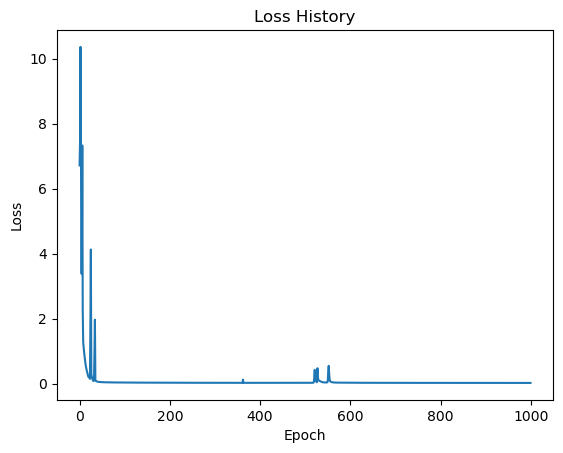

In [14]:
model_38.plot_loss()

Loss Choke 40

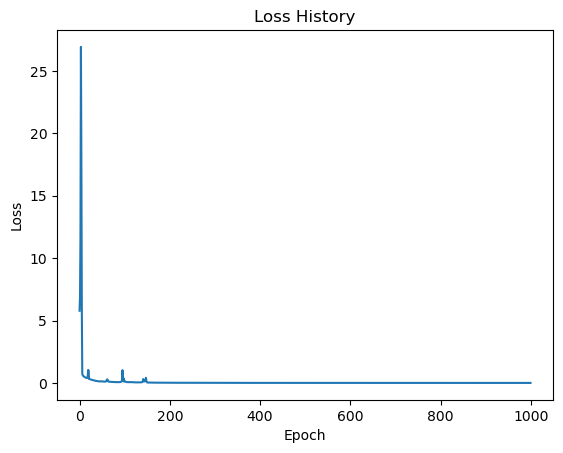

In [15]:
model_40.plot_loss()

Loss Choke 42

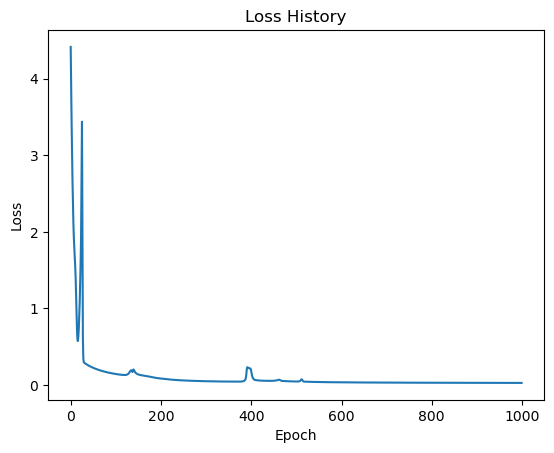

In [16]:
model_42.plot_loss()

# I. Evaluasi Model

In [17]:
mse_38, rmse_38, mape_38, mape_per_c_38 = model_38.evaluate(test_38_X.values, test_38_y.values)
mse_40, rmse_40, mape_40, mape_per_c_40 = model_40.evaluate(test_40_X.values, test_40_y.values)
mse_42, rmse_42, mape_42, mape_per_c_41 = model_42.evaluate(test_42_X.values, test_42_y.values)

print(f'MSE Choke 38: {mse_38}, RMSE Choke 38: {rmse_38}, MAPE Choke 38: {mape_38}, MAPE per column: {mape_per_c_38}')
print(f'MSE Choke 40: {mse_40}, RMSE Choke 40: {rmse_40}, MAPE Choke 40: {mape_40}, MAPE per column: {mape_per_c_40}')
print(f'MSE Choke 42: {mse_42}, RMSE Choke 42: {rmse_42}, MAPE Choke 42: {mape_42}, MAPE per column: {mape_per_c_41}')

MSE Choke 38: 0.002279269383255894, RMSE Choke 38: 0.04774169439029049, MAPE Choke 38: 1.5009840277588797, MAPE per column: [0.012965728869737054, 0.055665676033334825, 0.0753590411794207, 0.014808580455796003, 1.264206189874957, 0.07797881134563397]
MSE Choke 40: 0.0068464635875405, RMSE Choke 40: 0.0827433597791418, MAPE Choke 40: 5.76965143232139, MAPE per column: [0.08595786693267729, 0.1634642040779133, 2.2338057320375357, 0.10689854529613599, 1.4528466076958324, 1.7266784762812954]
MSE Choke 42: 0.008563033027654912, RMSE Choke 42: 0.09253665775061747, MAPE Choke 42: 8.451866082611101, MAPE per column: [2.342799093832837, 0.3835327111442308, 3.170640677116205, 0.06841818514958684, 0.07178509356200329, 2.414690321806239]


# J. Prediksi Data

### 1. Data Uji

In [18]:
predictions_38 = model_38.predict(test_38_X.values)
predictions_40 = model_40.predict(test_40_X.values)
predictions_42 = model_42.predict(test_42_X.values)

### 2. Data Latih

In [19]:
predictions_train_38 = model_38.predict(train_38_X.values)
predictions_train_40 = model_40.predict(train_40_X.values)
predictions_train_42 = model_42.predict(train_42_X.values)

# K. Denormalisasi Data

## 1. Membuat Fungsi untuk Denormalisasi Data

In [20]:
def denormalize_dataframe(np_normalized, df_original):
    # Denormalisasi DataFrame menggunakan metode Min-Max
    # np_normalized: numpy array yang sudah dinormalisasi
    # df_original: DataFrame asli sebelum dinormalisasi
    # return: DataFrame yang sudah denormalisasi

    assert isinstance(df_original, pd.DataFrame), 'df_original harus bertipe DataFrame'
    assert isinstance(np_normalized, np.ndarray), 'np_normalized harus bertipe numpy array'

    # Membuat salinan DataFrame yang sudah dinormalisasi
    df_normalized = pd.DataFrame(np_normalized, columns=df_original.columns)
    
    # Iterasi setiap kolom dalam DataFrame
    for column in df_normalized.columns:
        # Ambil nilai minimum dan maksimum dari kolom
        min_value = df_original[column].min()
        max_value = df_original[column].max()
        
        # Denormalisasi setiap nilai dalam kolom
        df_normalized[column] = df_normalized[column] * (max_value - min_value) + min_value
        
    return df_normalized

## 2. Denormalisasi Data

In [21]:
denormalized_predictions_38 = denormalize_dataframe(predictions_38, data_38)
denormalized_predictions_40 = denormalize_dataframe(predictions_40, data_40)
denormalized_predictions_42 = denormalize_dataframe(predictions_42, data_42)

denormalized_predictions_train_38 = denormalize_dataframe(predictions_train_38, data_38)
denormalized_predictions_train_40 = denormalize_dataframe(predictions_train_40, data_40)
denormalized_predictions_train_42 = denormalize_dataframe(predictions_train_42, data_42)

denormalized_test_38_y = denormalize_dataframe(test_38_y.values, data_38)
denormalized_test_40_y = denormalize_dataframe(test_40_y.values, data_40)
denormalized_test_42_y = denormalize_dataframe(test_42_y.values, data_42)

denormalized_train_38_y = denormalize_dataframe(train_38_y.values, data_38)
denormalized_train_40_y = denormalize_dataframe(train_40_y.values, data_40)
denormalized_train_42_y = denormalize_dataframe(train_42_y.values, data_42)

# L. Visualisasi Data

## 1. Data Choke 38

In [22]:
import matplotlib.dates as mdates
# Define a function to format x-ticks for datetime
def format_date_ticks(ax, date_format='%Y/%m/%d %H:%M:%S'):
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter(date_format))


/home/ubaid/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


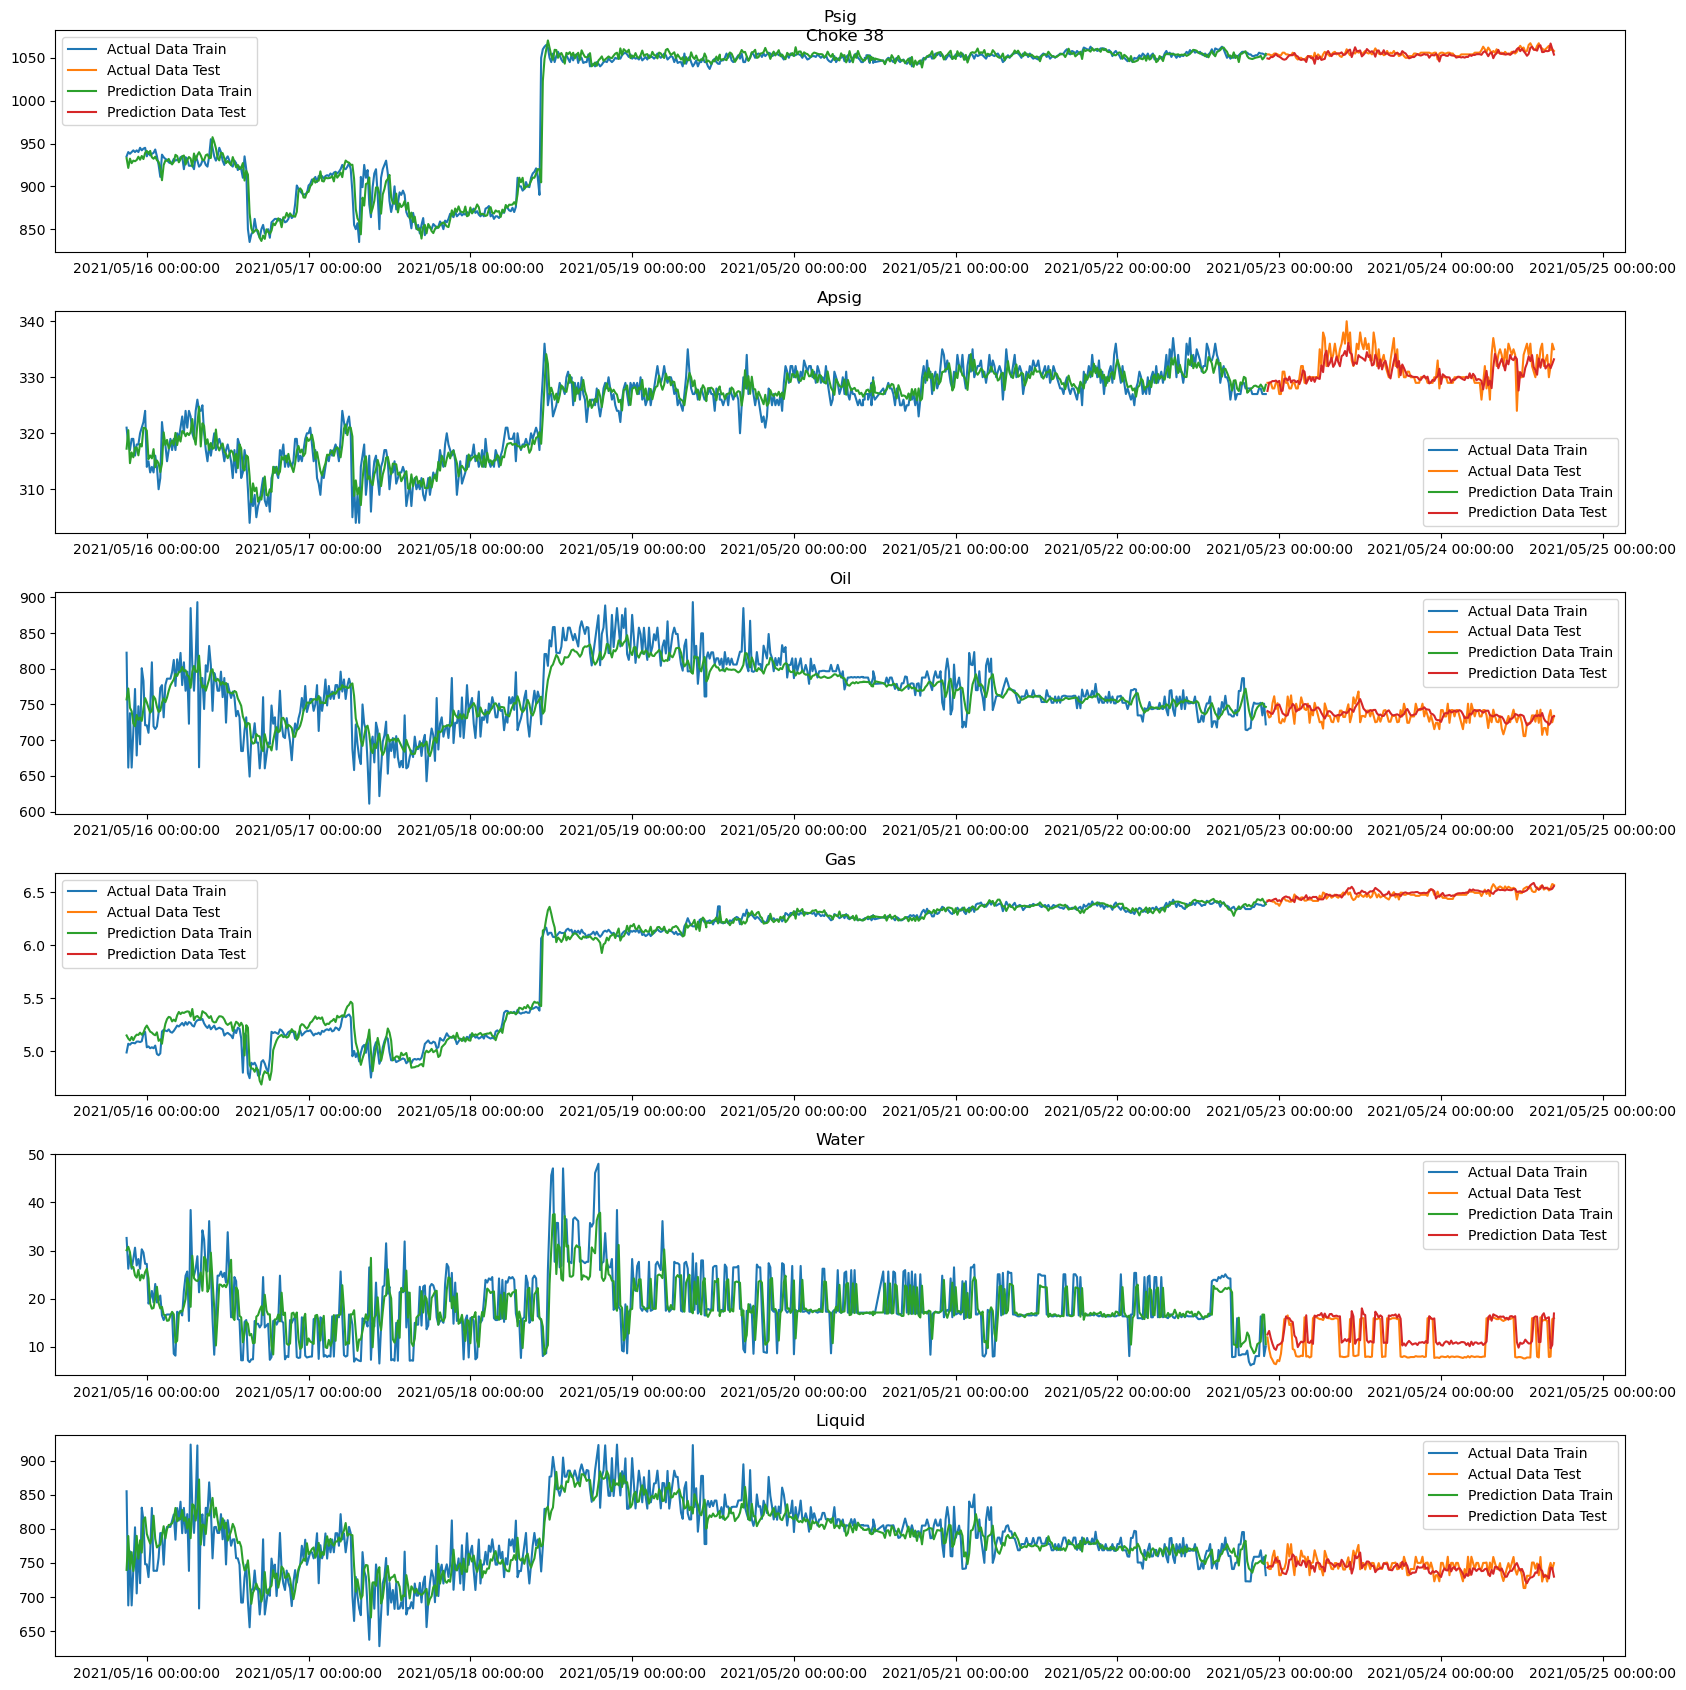

In [23]:
fig, axes = plt.subplots(figsize=(17, 17), nrows=denormalized_train_38_y.shape[1])

for i, ax in enumerate(axes):
    # Plot training data
    ax.plot(data['datetime'].iloc[:denormalized_train_38_y.shape[0]],
            denormalized_train_38_y.iloc[:, i], label='Actual Data Train')
    
    # Plot testing data
    ax.plot(data['datetime'].iloc[denormalized_train_38_y.shape[0]:denormalized_train_38_y.shape[0]+denormalized_test_38_y.shape[0]],
        denormalized_test_38_y.iloc[:, i], label='Actual Data Test')
    
    # Plot Prediction Training
    ax.plot(data['datetime'].iloc[:denormalized_train_38_y.shape[0]],
            denormalized_predictions_train_38.iloc[:, i], label='Prediction Data Train')
            
    # Plot predictions
    ax.plot(data['datetime'].iloc[denormalized_train_38_y.shape[0]:denormalized_train_38_y.shape[0]+denormalized_test_38_y.shape[0]],
            denormalized_predictions_38.iloc[:, i], label='Prediction Data Test')
    

    ax.set_title(denormalized_train_38_y.columns[i].capitalize())
    format_date_ticks(ax)
    ax.legend()

    # reset ticks every week data['datetime'] as xticks
    # ax.set_xticks(data.index)
    

plt.tight_layout()
fig.suptitle('Choke 38')
fig.savefig('choke_38.png')
fig.show()

## 2. Data Choke 40

/home/ubaid/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


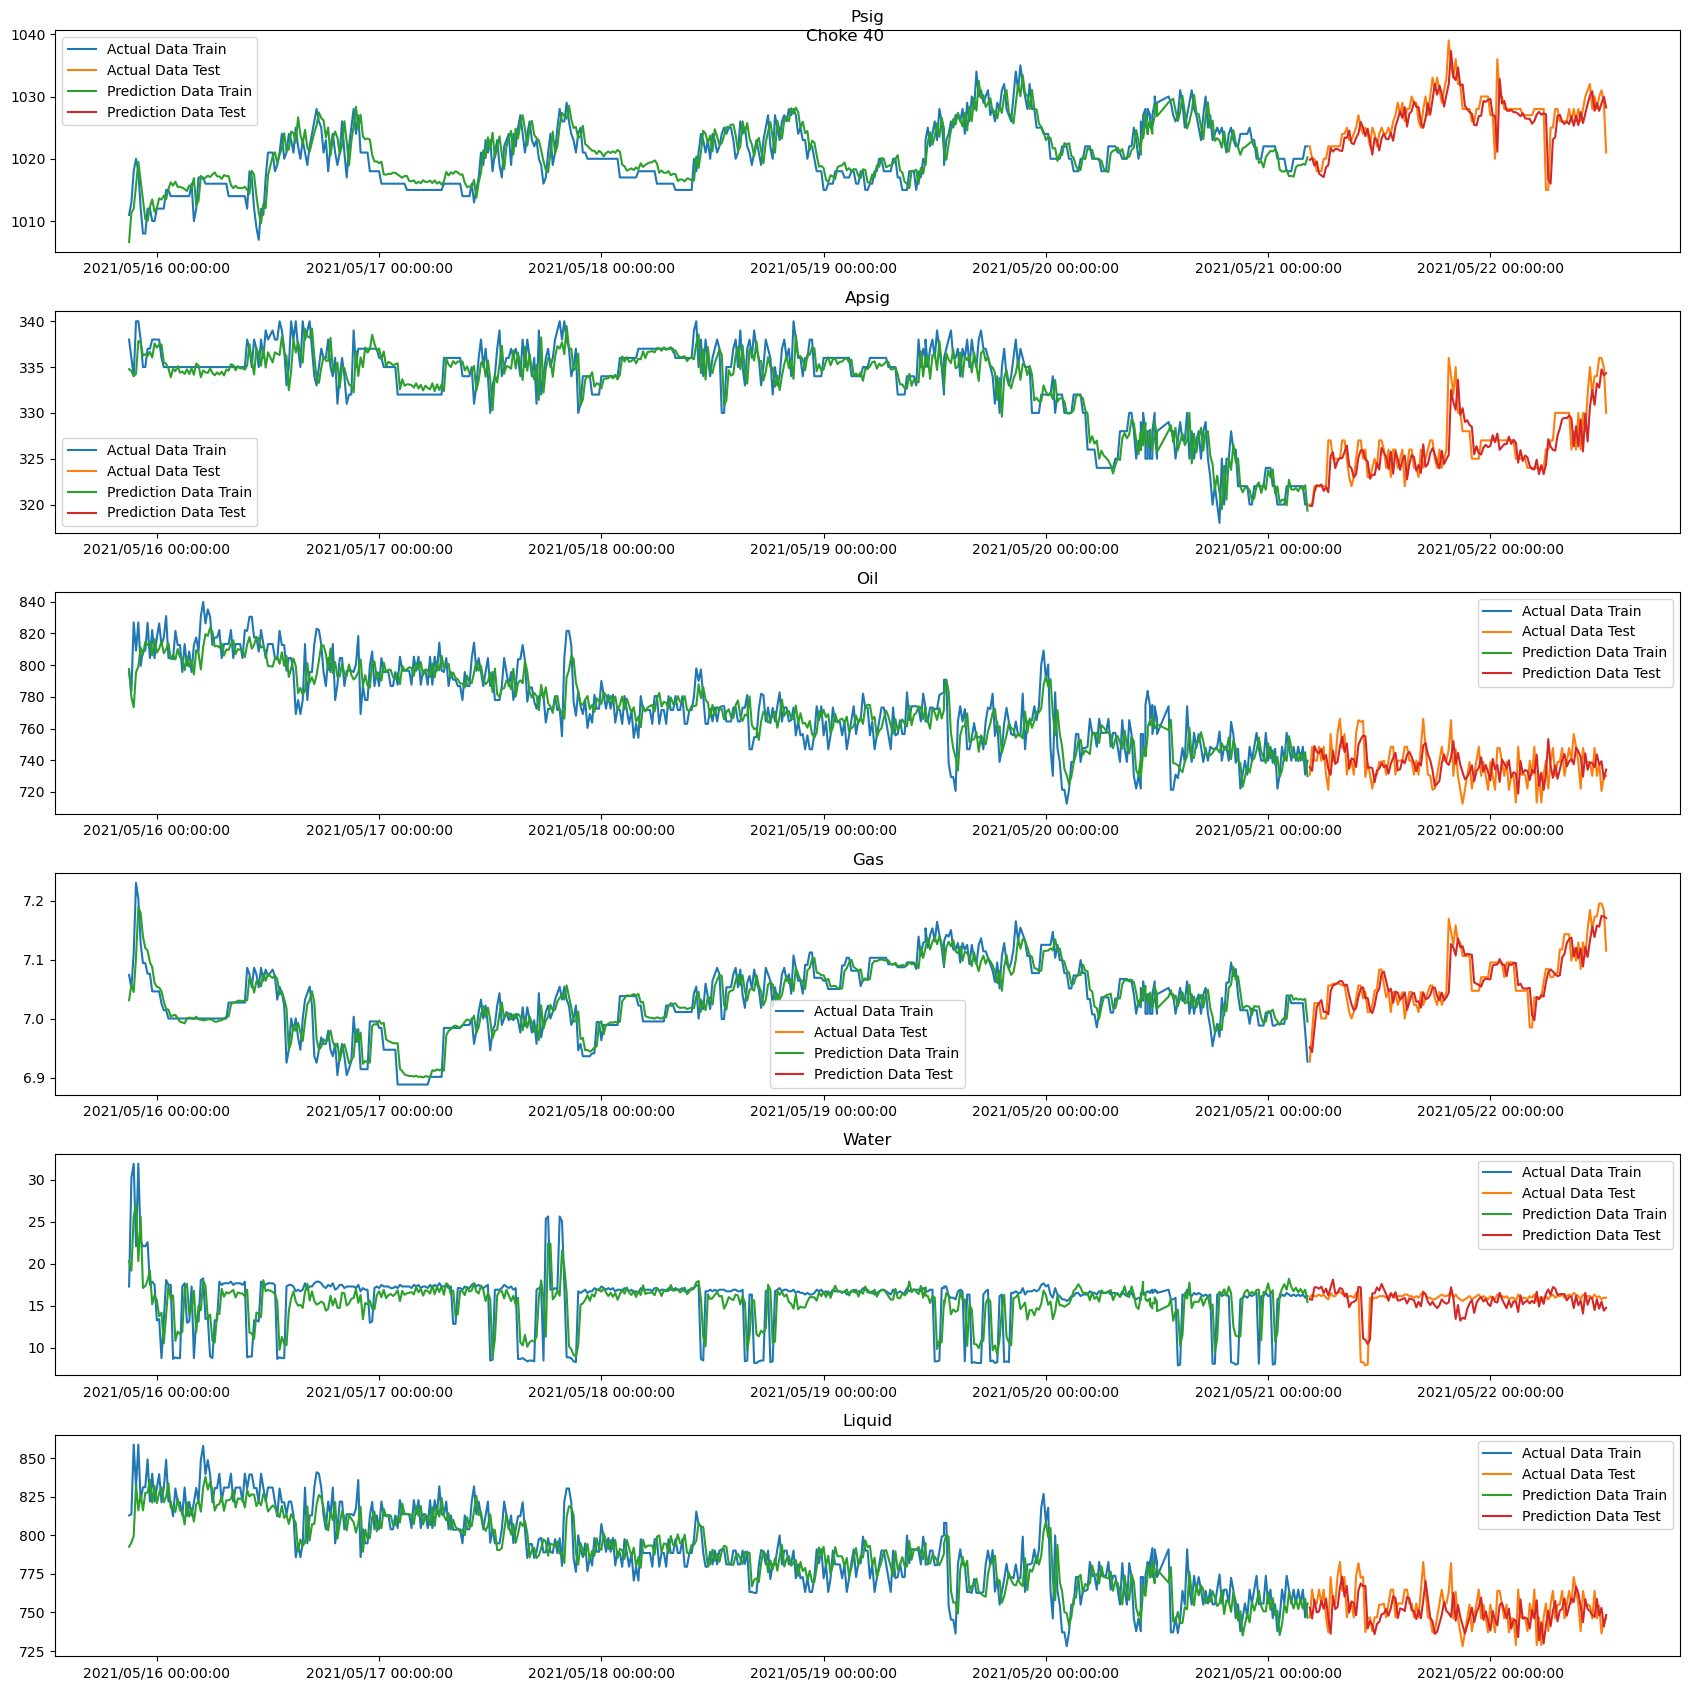

In [24]:
fig, axes = plt.subplots(figsize=(17, 17), nrows=denormalized_train_40_y.shape[1])

for i, ax in enumerate(axes):
    # Plot training data
    ax.plot(data['datetime'].iloc[:denormalized_train_40_y.shape[0]],
            denormalized_train_40_y.iloc[:, i], label='Actual Data Train')
    
    # Plot testing data
    ax.plot(data['datetime'].iloc[denormalized_train_40_y.shape[0]:denormalized_train_40_y.shape[0]+denormalized_test_40_y.shape[0]],
        denormalized_test_40_y.iloc[:, i], label='Actual Data Test')
    
    # Plot Prediction Training
    ax.plot(data['datetime'].iloc[:denormalized_train_40_y.shape[0]],
            denormalized_predictions_train_40.iloc[:, i], label='Prediction Data Train')
    
    # Plot predictions
    ax.plot(data['datetime'].iloc[denormalized_train_40_y.shape[0]:denormalized_train_40_y.shape[0]+denormalized_test_40_y.shape[0]],
            denormalized_predictions_40.iloc[:, i], label='Prediction Data Test')
    
    ax.set_title(denormalized_train_40_y.columns[i].capitalize())
    ax.legend()
    format_date_ticks(ax)

fig.tight_layout()
fig.suptitle('Choke 40')
fig.savefig('choke_40.png')
fig.show()

## 3. Data Choke 42

/home/ubaid/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


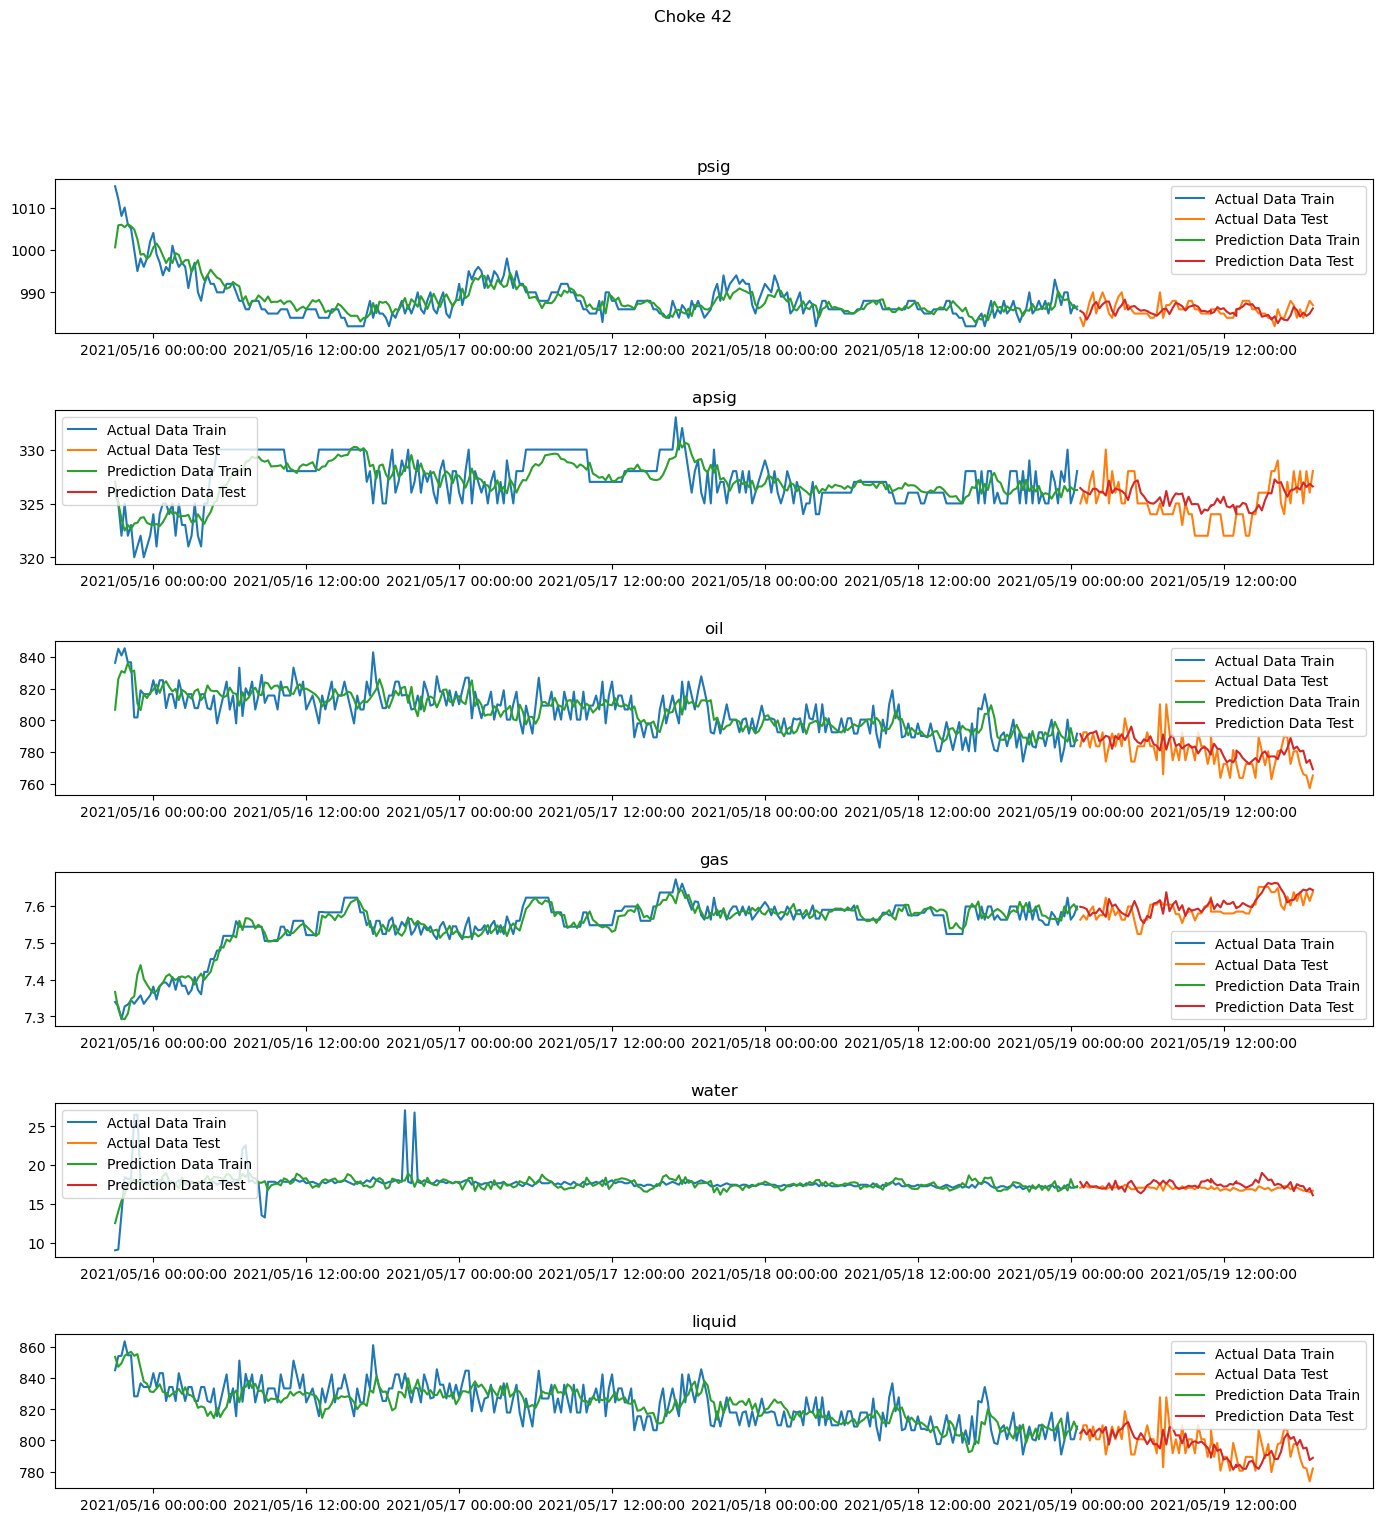

In [25]:
fig, axes = plt.subplots(figsize=(17, 17), nrows=denormalized_train_42_y.shape[1])

for i, ax in enumerate(axes):
    # Plot training data
    ax.plot(data['datetime'].iloc[:denormalized_train_42_y.shape[0]],
            denormalized_train_42_y.iloc[:, i], label='Actual Data Train')

    # Plot testing data
    ax.plot(data['datetime'].iloc[denormalized_train_42_y.shape[0]:denormalized_train_42_y.shape[0] + denormalized_test_42_y.shape[0]],
            denormalized_test_42_y.iloc[:, i], label='Actual Data Test')
    
    # Plot Prediction Training
    ax.plot(data['datetime'].iloc[:denormalized_train_42_y.shape[0]],
            denormalized_predictions_train_42.iloc[:, i], label='Prediction Data Train')

    # Plot predictions
    ax.plot(data['datetime'].iloc[denormalized_train_42_y.shape[0]:denormalized_train_42_y.shape[0] + denormalized_test_42_y.shape[0]],
            denormalized_predictions_42.iloc[:, i], label='Prediction Data Test')
    
    ax.set_title(denormalized_train_42_y.columns[i])
    ax.legend()
    format_date_ticks(ax)

fig.subplots_adjust(hspace=0.5)
fig.suptitle('Choke 42')
fig.savefig('choke_42.png')
fig.show()

## 4. Perbandingan Data Choke 38, 40, dan 42 pada setiap feature

/home/ubaid/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


,Choke 38,Choke 40,Choke 42
psig,180242.431688,132360.844219,74918.246029
apsig,56628.258466,42069.966146,24746.224070
oil,126158.378276,95154.128184,59502.916140
gas,1109.953869,911.424256,578.053553
water,2250.565220,2015.750143,1326.916500
liquid,126957.176955,96831.100211,60577.448172


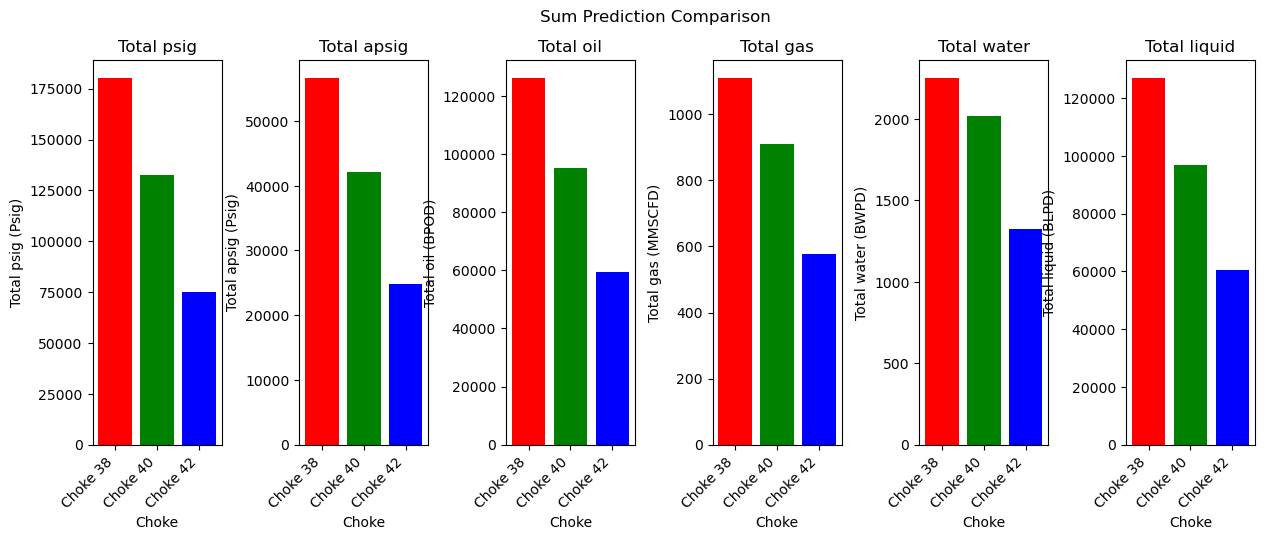

In [26]:
prediction_sum_38 = denormalized_predictions_38.sum()
prediction_sum_40 = denormalized_predictions_40.sum()
prediction_sum_42 = denormalized_predictions_42.sum()
prediction_sums = {
    'Choke 38': prediction_sum_38,
    'Choke 40': prediction_sum_40,
    'Choke 42': prediction_sum_42
}

units = ['Psig', 'Psig', 'BPOD', 'MMSCFD', 'BWPD', 'BLPD']

# plot sum prediction comparison bar
fig, axes = plt.subplots(figsize=(15, 5), ncols=len(prediction_sum_38.index))

for i, column in enumerate(prediction_sum_38.index):
    axes[i].bar(prediction_sums.keys(), [prediction_sum_38[i], prediction_sum_40[i], prediction_sum_42[i]], color=['red', 'green', 'blue'])
    axes[i].set_title('Total ' + column)
    axes[i].set_ylabel(f'Total {column} ({units[i]})')
    axes[i].set_xlabel('Choke')
    plt.setp(axes[i].get_xticklabels(), rotation=45, ha='right')

fig.subplots_adjust(wspace=0.6)
fig.suptitle('Sum Prediction Comparison')
fig.savefig('sum_prediction_comparison.png')
fig.show()

# display as table
pd.DataFrame(prediction_sums)

/home/ubaid/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


,Choke 38,Choke 40,Choke 42
psig,1054.049308,1026.053056,985.766395
apsig,331.159406,326.123769,325.608211
oil,737.768294,737.628901,782.933107
gas,6.490958,7.065304,7.605968
water,13.161200,15.625970,17.459428
liquid,742.439631,750.628684,797.071686


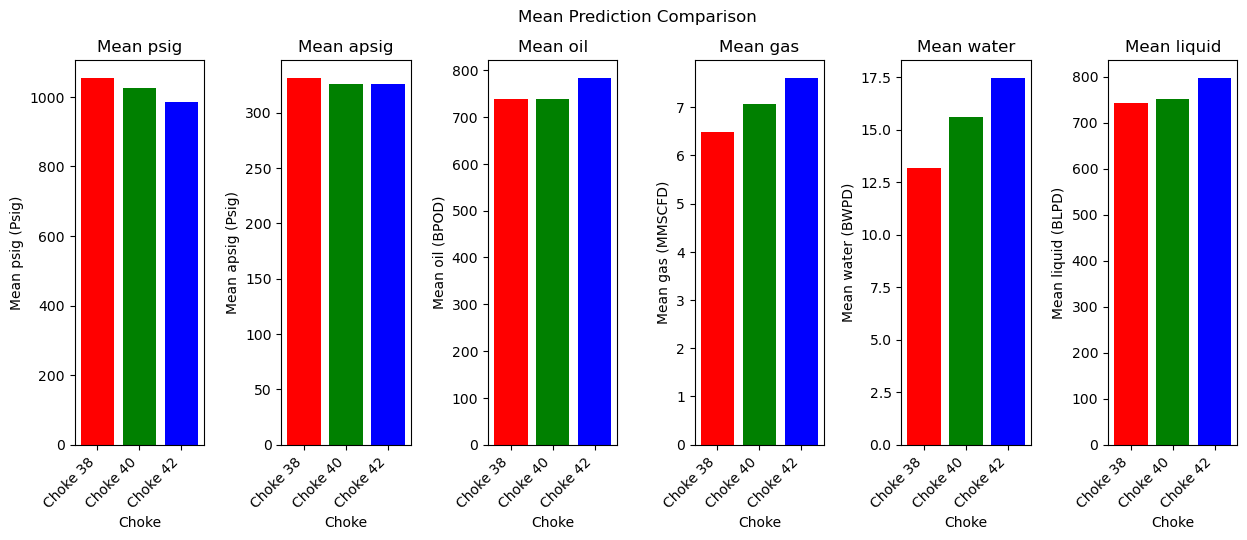

In [27]:
prediction_mean_38 = denormalized_predictions_38.mean()
prediction_mean_40 = denormalized_predictions_40.mean()
prediction_mean_42 = denormalized_predictions_42.mean()

prediction_means = {
    'Choke 38': prediction_mean_38,
    'Choke 40': prediction_mean_40,
    'Choke 42': prediction_mean_42
}

# plot mean prediction comparison bar
fig, axes = plt.subplots(figsize=(15, 5), ncols=len(prediction_mean_38.index))

for i, column in enumerate(prediction_mean_38.index):
    axes[i].bar(prediction_means.keys(), [prediction_mean_38[i], prediction_mean_40[i], prediction_mean_42[i]], color=['red', 'green', 'blue'])
    axes[i].set_title('Mean ' + column)
    axes[i].set_ylabel(f'Mean {column} ({units[i]})')
    axes[i].set_xlabel('Choke')
    plt.setp(axes[i].get_xticklabels(), rotation=45, ha='right')

fig.subplots_adjust(wspace=0.6)
fig.suptitle('Mean Prediction Comparison')
fig.savefig('mean_prediction_comparison.png')
fig.show()

# display as table
pd.DataFrame(prediction_means)

# M. Kombinasikan Semua Data Prediksi


In [28]:
predictions_all = pd.concat([denormalized_predictions_train_38, denormalized_predictions_38, denormalized_predictions_train_40, denormalized_predictions_40, denormalized_predictions_train_42, denormalized_predictions_42])
predictions_all.reset_index(drop=True, inplace=True)
predictions_all['choke'] = [38] * len(denormalized_predictions_train_38) + [38] * len(denormalized_predictions_38) + [40] * len(denormalized_predictions_train_40) + [40] * len(denormalized_predictions_40) + [42] * len(denormalized_predictions_train_42) + [42] * len(denormalized_predictions_42)
predictions_all['datetime'] = data['datetime']
# move choke and datetime to front
predictions_all = predictions_all[['datetime', 'choke'] + [col for col in predictions_all.columns if col not in ['datetime', 'choke']]]
predictions_all.to_csv('predictions_all.csv', index=False)
predictions_all

,datetime,choke,psig,apsig,oil,gas,water,liquid
0,2021-05-15 21:00:00,38,933.035930,317.266277,757.134752,5.150131,30.079901,739.883287
1,2021-05-15 21:15:00,38,921.598640,320.573231,772.361952,5.120524,30.774142,789.515593
2,2021-05-15 21:30:00,38,932.451084,314.686217,745.349508,5.103352,29.652166,741.375969
3,2021-05-15 21:45:00,38,927.190872,316.601562,740.579694,5.135770,26.499666,765.908078
4,2021-05-15 22:00:00,38,930.151610,315.723790,723.481976,5.105891,26.580825,738.256368
...,...,...,...,...,...,...,...,...
1870,2021-06-04 07:15:00,42,984.333373,326.297103,780.464991,7.635860,17.343597,800.352344
1871,2021-06-04 07:30:00,42,985.250569,326.959002,780.927356,7.644915,17.295190,794.834621
1872,2021-06-04 07:45:00,42,984.474506,326.531875,773.274317,7.642241,16.633131,795.407523
1873,2021-06-04 08:00:00,42,985.023058,326.828965,775.117358,7.647907,17.051527,787.420409


# N. Visualisasi Data Prediksi

/home/ubaid/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


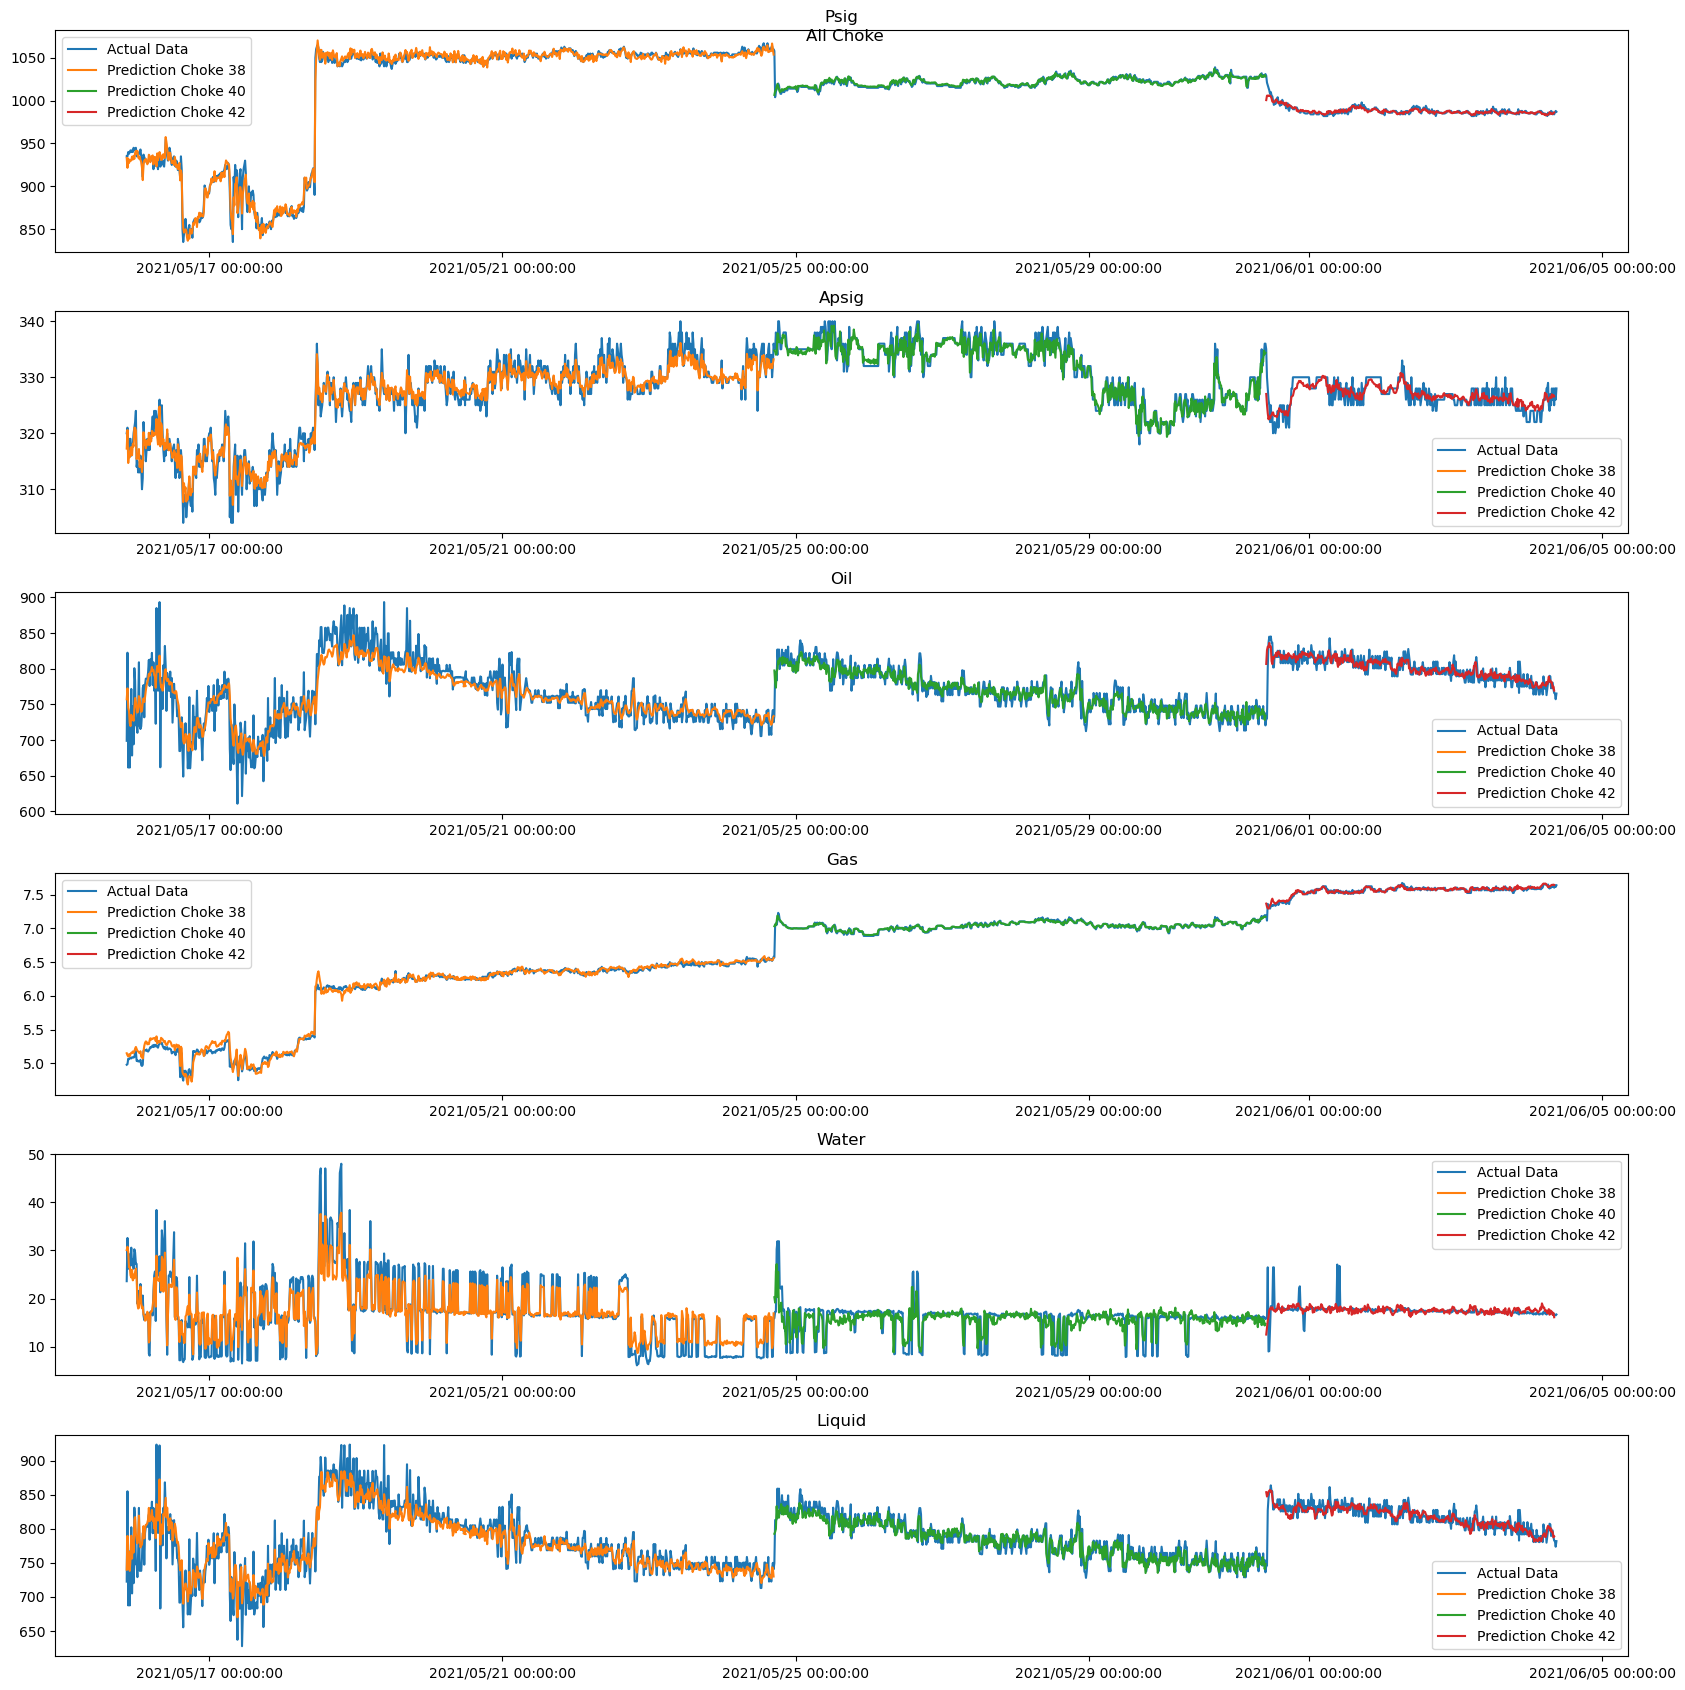

In [29]:
fig, axes = plt.subplots(figsize=(17, 17), nrows=denormalized_train_38_y.shape[1])
for i, ax in enumerate(axes):
    ax.plot(data['datetime'], data[data.columns[i+2]], label='Actual Data')

    for choke in [38, 40, 42]:
        ax.plot(predictions_all[predictions_all['choke'] == choke]['datetime'], predictions_all[predictions_all['choke'] == choke][predictions_all.columns[i+2]], label=f'Prediction Choke {choke}')

    ax.set_title(data.columns[i+2].capitalize())
    format_date_ticks(ax)
    ax.legend()
  
plt.tight_layout()
fig.suptitle('All Choke')
fig.savefig('all_choke.png')
fig.show()

# O. Ratio Liquid Output

In [30]:
predictions_all_date = predictions_all.copy()
predictions_all_date['date'] = predictions_all_date['datetime'].dt.date
predictions_all_date['week'] = predictions_all_date['datetime'].dt.isocalendar().week
predictions_all_date['month'] = predictions_all_date['datetime'].dt.month

# SUM
predictions_all_date_grouped_sum = predictions_all_date.drop(['week', 'month', 'liquid'], axis=1).groupby(['choke', 'date']).sum(numeric_only=True).reset_index()
# predictions_all_date_grouped_sum['liquid']
predictions_all_date_grouped_sum.to_csv('predictions_all_date_grouped_sum.csv', index=False)

predictions_all_week_grouped_sum = predictions_all_date.drop(['date', 'month', 'liquid'], axis=1).groupby(['choke', 'week']).sum(numeric_only=True).reset_index()
# predictions_all_week_grouped_sum['liquid']
predictions_all_week_grouped_sum.to_csv('predictions_all_week_grouped_sum.csv', index=False)

predictions_all_month_grouped_sum = predictions_all_date.drop(['week', 'date', 'liquid'], axis=1).groupby(['choke', 'month']).sum(numeric_only=True).reset_index()
# predictions_all_month_grouped_sum['liquid']
predictions_all_month_grouped_sum.to_csv('predictions_all_month_grouped_sum.csv', index=False)

# MEAN
predictions_all_date_grouped_mean = predictions_all_date.drop(['week', 'month', 'liquid'], axis=1).groupby(['choke', 'date']).mean(numeric_only=True).reset_index()
# predictions_all_date_grouped_mean['liquid']
predictions_all_date_grouped_mean.to_csv('predictions_all_date_grouped_mean.csv', index=False)

predictions_all_week_grouped_mean = predictions_all_date.drop(['date', 'month', 'liquid'], axis=1).groupby(['choke', 'week']).mean(numeric_only=True).reset_index()
# predictions_all_week_grouped_mean['liquid']
predictions_all_week_grouped_mean.to_csv('predictions_all_week_grouped_mean.csv', index=False)

predictions_all_month_grouped_mean = predictions_all_date.drop(['week', 'date', 'liquid'], axis=1).groupby(['choke', 'month']).mean(numeric_only=True).reset_index()
# predictions_all_month_grouped_mean['liquid']
predictions_all_month_grouped_mean.to_csv('predictions_all_month_grouped_mean.csv', index=False)

display(predictions_all_date_grouped_sum)
display(predictions_all_date_grouped_mean)
display(predictions_all_week_grouped_sum)
display(predictions_all_week_grouped_mean)
display(predictions_all_month_grouped_sum)
display(predictions_all_month_grouped_mean)

,choke,date,psig,apsig,oil,gas,water
0,38,2021-05-15,11177.313146,3813.561575,8883.752275,61.796088,317.345552
1,38,2021-05-16,86033.177077,30025.936144,71232.583061,492.020925,1708.657822
2,38,2021-05-17,84781.129186,30157.924198,69300.187247,489.788302,1557.512761
3,38,2021-05-18,93802.429314,30967.008516,75345.260559,550.645417,2090.102976
4,38,2021-05-19,103110.394481,32114.441904,79211.289721,608.374638,1934.857633
5,38,2021-05-20,105068.495536,32863.147353,78115.504263,628.393613,1821.768334
6,38,2021-05-21,101231.407174,31708.874220,73204.102229,611.098932,1717.862164
7,38,2021-05-22,101044.826521,31687.413730,71756.282894,612.327251,1562.180198
8,38,2021-05-23,101111.836391,31809.799133,71059.211178,621.970185,1297.110788
9,38,2021-05-24,71771.687111,22515.513028,49905.371108,443.004352,875.627582


,choke,date,psig,apsig,oil,gas,water
0,38,2021-05-15,931.442762,317.796798,740.312690,5.149674,26.445463
1,38,2021-05-16,905.612390,316.062486,749.816664,5.179168,17.985872
2,38,2021-05-17,883.136762,314.145044,721.876950,5.101961,16.224091
3,38,2021-05-18,977.108639,322.573005,784.846464,5.735890,21.771906
4,38,2021-05-19,1052.146882,327.698387,808.278467,6.207904,19.743445
5,38,2021-05-20,1050.684955,328.631474,781.155043,6.283936,18.217683
6,38,2021-05-21,1054.493825,330.300773,762.542732,6.365614,17.894398
7,38,2021-05-22,1052.550276,330.077226,747.461280,6.378409,16.272710
8,38,2021-05-23,1053.248296,331.352074,740.200116,6.478856,13.511571
9,38,2021-05-24,1055.465987,331.110486,733.902516,6.514770,12.876876


,choke,week,psig,apsig,oil,gas,water
0,38,19,97210.490224,33839.497719,80116.335336,553.817013,2026.003374
1,38,20,690150.518604,221308.609054,517991.838092,4122.598338,11981.394855
2,38,21,71771.687111,22515.513028,49905.371108,443.004352,875.627582
3,40,21,617171.286507,200448.683551,464624.184038,4249.050860,9379.579756
4,40,22,41059.059928,13109.925784,29429.241555,283.721531,627.123914
5,42,22,373532.136971,123521.599759,302921.595351,2857.653524,6644.163645


,choke,week,psig,apsig,oil,gas,water
0,38,19,908.509254,316.256988,748.750798,5.175860,18.934611
1,38,20,1017.921119,326.413878,763.999761,6.080529,17.671674
2,38,21,1055.465987,331.110486,733.902516,6.514770,12.876876
3,40,21,1021.806766,331.868681,769.245338,7.034852,15.529106
4,40,22,1026.476498,327.748145,735.731039,7.093038,15.678098
5,42,22,988.180257,326.776719,801.379882,7.559930,17.577153


,choke,month,psig,apsig,oil,gas,water
0,38,5,859132.695938,277663.619801,648013.544536,5119.419704,14883.025810
1,40,5,658230.346435,213558.609335,494053.425592,4532.772391,10006.703670
2,42,5,55720.813431,18234.252528,45856.320936,416.907194,992.487246
3,42,6,317811.323540,105287.347231,257065.274415,2440.746330,5651.676399


,choke,month,psig,apsig,oil,gas,water
0,38,5,1007.189561,325.514208,759.687625,6.001664,17.447861
1,40,5,1022.096811,331.612747,767.163704,7.038466,15.538360
2,42,5,995.014526,325.611652,818.862874,7.444771,17.722987
3,42,6,986.991688,326.979339,798.339362,7.579958,17.551790
